# Motivation Figures: Issue 1 — Resource Underutilization

Generates two paper-ready figures from the MATH baseline sweep CSV:
- Average latency at 50/100/200 requests per minute
- Average queue depth at 50/100/200 requests per minute


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style='whitegrid')
plt.rcParams.update({
    'figure.figsize': (15, 4.6),
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'legend.fontsize': 9,
    'axes.edgecolor': '#333333',
    'grid.color': '#E5E5E5',
    'grid.linewidth': 0.8,
})

CSV_NAME = 'baseline_motivation_sweep_math_test_1000_poisson_2.csv'
candidates = [
    Path('logs/motivation_plot_generator_data') / CSV_NAME,
    Path('..') / 'logs/motivation_plot_generator_data' / CSV_NAME,
]
for path in candidates:
    if path.exists():
        DATA_PATH = path
        break
else:
    raise FileNotFoundError(f'Could not find {CSV_NAME}. Tried: ' + ', '.join(str(p) for p in candidates))

df = pd.read_csv(DATA_PATH)
step_df = df[df.record_type == 'step'].copy()

for col in ['latency_seconds', 'arrival_rate', 'llm_running', 'llm_waiting']:
    step_df[col] = pd.to_numeric(step_df[col], errors='coerce')

step_df['queue_depth'] = step_df['llm_running'].fillna(0) + step_df['llm_waiting'].fillna(0)

MODEL_ORDER = [
    'meta-llama/Llama-3.2-3B-Instruct',
    'meta-llama/Llama-3.1-8B-Instruct',
    'Qwen/Qwen2.5-Coder-14B-Instruct',
    'mistralai/Mistral-Small-24B-Instruct-2501',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B',
]
models_in_data = [m for m in MODEL_ORDER if m in step_df['llm_name'].unique()]

ARRIVAL_RATES = [50.0, 100.0, 200.0]
step_df = step_df[step_df['arrival_rate'].isin(ARRIVAL_RATES)].copy()

print(f'Loaded: {DATA_PATH.resolve()}')
print(f'Arrival rates: {ARRIVAL_RATES}')
print(f'Models: {models_in_data}')


Loaded: /home/ahasan/projects/infra-mind/logs/motivation_plot_generator_data/baseline_motivation_sweep_math_test_1000_poisson_2.csv
Arrival rates: [50.0, 100.0, 200.0]
Models: ['meta-llama/Llama-3.2-3B-Instruct', 'meta-llama/Llama-3.1-8B-Instruct', 'Qwen/Qwen2.5-Coder-14B-Instruct', 'mistralai/Mistral-Small-24B-Instruct-2501', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B']


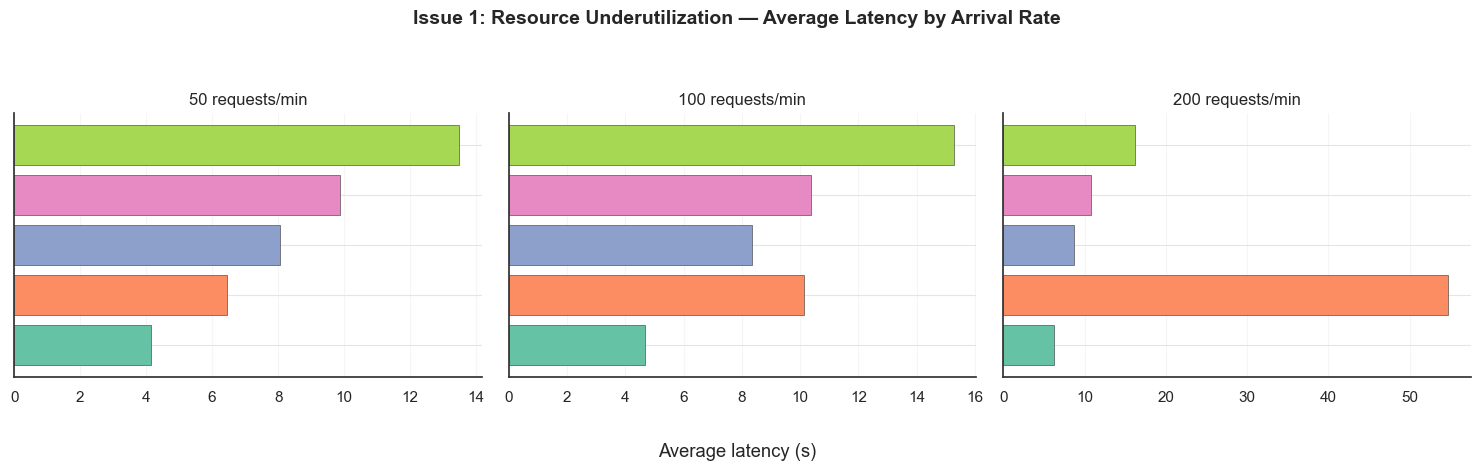

Saved: /home/ahasan/projects/infra-mind/visualization/output_plots/issue1_latency_by_arrival_rate.png


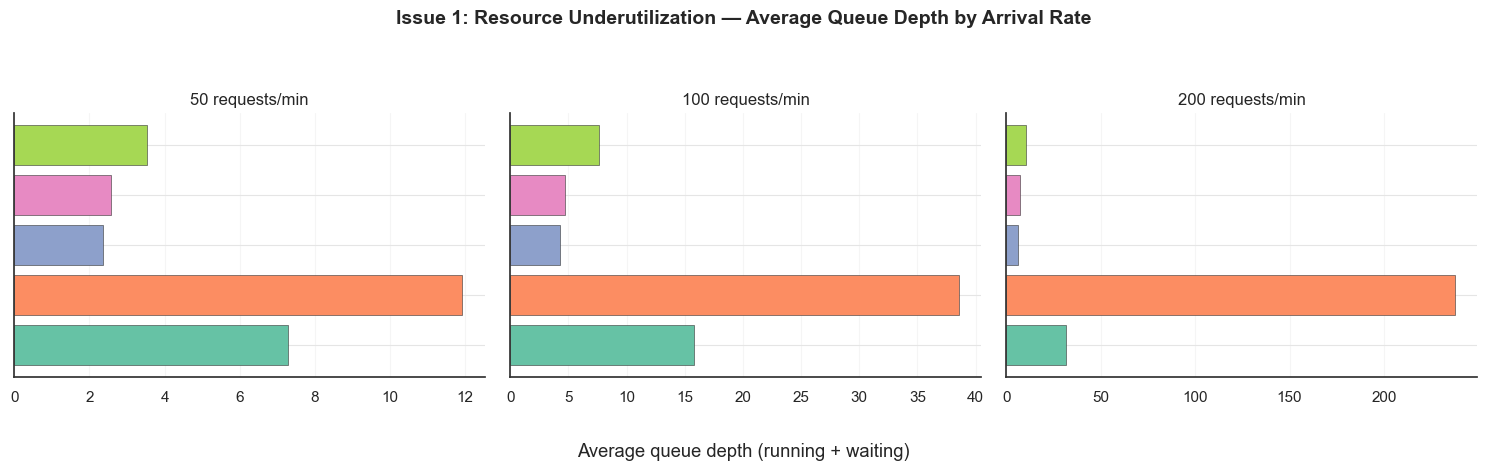

Saved: /home/ahasan/projects/infra-mind/visualization/output_plots/issue1_queue_depth_by_arrival_rate.png


In [22]:
MODEL_COLORS = sns.color_palette('Set2', n_colors=len(models_in_data))
COLOR_MAP = dict(zip(models_in_data, MODEL_COLORS))

def plot_metric_panels(metric, metric_label, title, filename):
    stats = (
        step_df.groupby(['arrival_rate', 'llm_name'])[metric]
        .mean()
        .reset_index()
    )
    pivot = (
        stats.pivot(index='llm_name', columns='arrival_rate', values=metric)
        .reindex(index=models_in_data, columns=ARRIVAL_RATES)
    )

    fig, axes = plt.subplots(1, len(ARRIVAL_RATES), figsize=(15, 4.6), sharey=True)
    if len(ARRIVAL_RATES) == 1:
        axes = [axes]

    y = np.arange(len(models_in_data))
    for ax, rate in zip(axes, ARRIVAL_RATES):
        vals = pivot[rate].values
        ax.barh(
            y,
            vals,
            color=[COLOR_MAP[m] for m in models_in_data],
            edgecolor='#333333',
            linewidth=0.4,
        )
        ax.set_title(f'{int(rate)} requests/min')
        ax.grid(True, axis='x', alpha=0.35)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if ax is axes[0]:
            ax.set_yticks(y)
            ax.set_yticklabels(models_in_data, fontsize=9)
        else:
            ax.set_yticklabels([])

    fig.supxlabel(metric_label, y=0.04)
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    fig.tight_layout(rect=[0, 0.05, 1, 0.95])

    output_dir = Path('visualization/output_plots') if Path('visualization').exists() else Path('output_plots')
    output_dir.mkdir(parents=True, exist_ok=True)
    output_path = output_dir / filename
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'Saved: {output_path.resolve()}')

plot_metric_panels(
    metric='latency_seconds',
    metric_label='Average latency (s)',
    title='Issue 1: Resource Underutilization — Average Latency by Arrival Rate',
    filename='issue1_latency_by_arrival_rate.png',
)

plot_metric_panels(
    metric='queue_depth',
    metric_label='Average queue depth (running + waiting)',
    title='Issue 1: Resource Underutilization — Average Queue Depth by Arrival Rate',
    filename='issue1_queue_depth_by_arrival_rate.png',
)
